In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [2]:
!pip install psycopg2-binary

In [3]:
import psycopg2 as pg

con = pg.connect("dbname=datawarehouse user=jarvis_ro password=XJk%72kV host=prod-dwh.cxmfelfcussu.ap-southeast-1.rds.amazonaws.com port=5432")
cur = con.cursor()

query = """
-- the original code for AOV cluster

with order_with_flushout as ( -- per item
	select dp.reference,
	fo.id_order,
	dos.store_alias ,
	dc.id_customer,
	(case
		when doc.id is not null
			or foi.is_offlinestore_guest = 1 then 1
		else 0
	end) is_guest,
	foi.total_product_quantity,
	foi.after_discount,
	foi.before_discount,
	(case when (1-(case when before_discount > 0 and after_discount > 0 then after_discount::float / before_discount::float else 1 end)) >= 0.60 and dp.brand != 'skin1004' then 1
		when dp.brand = 'skin1004' and dp.category_default = 'sheet mask' then 1
		else 0
		end
	) is_excluded,
	(1-(case when before_discount > 0 and after_discount > 0 then after_discount::float / before_discount::float else 1 end)) discount
	from
		dwh_revamp.fact_order fo
		left join dwh_revamp.fact_order_item foi on
	fo.id_order = foi.id_order
		left join dwh_revamp.dim_product dp on
	dp.id = foi.id_product
		left join dwh_revamp.dim_customer dc on
	dc.id = foi.id_customer
		left join dwh_revamp.dim_offlinestore_store dos on
	dos.id = foi.id_offlinestore_store
		left join dwh_revamp.dim_offlinestore_cashier doc on
	doc.customer_id = dc.id
		left join dwh_revamp.dim_city dc2 on
	dc2.id = dos.city_id
		left join dwh_revamp.dim_province dp2 on
	dp2.id = dos.province_id
	where
	foi.data_source = 'sociolla'
		and foi.sociolla_is_net = 1
		and foi.order_type != 'Egift'
		and foi.order_date between '2024-01-01' and '2024-06-30'
		and foi.id_order_platform = 4
		and dos.store_alias not in ('PE3','XTP','PSF','PE2','SMC','SBM','SKT','SSR','SCB','SKW','SDM','SBP','SBQ','SPR','VVS','SIB') --not in 2024 stores
		and dp.base_price > 2
		and (foi.order_product_type = 'original'::enum_sociolla_order_product_type
		or ( foi.order_product_type = 'gift-with-purchase'::enum_sociolla_order_product_type
		and dp.product_classification = 'sellable_products'))
		and dp.id not in (124957, 124958, 124961, 126938, 126942, 126940, 126936, 116486, 116489, 116485, 113660, 113711, 113661, 
	85154, 52611, 89814, 108440, 108442, 68508, 68689, 68722, 85160, 89810, 89813, 108437, 124954, 127938, 127934, 127929, 124955, 
	127886, 127885, 127930, 127933, 127937, 154732, 154730, 154731, 154729, 154727, 154728, 105602, 116488, 116489, 117213, 117214, 117215)
	group by 1,2,3,4,5,6,7,8,9
)


select
	store_alias,
	(case
		when ad <= 50000 then 'a. <50k'
		when ad > 50000 and ad <= 100000 then 'b. >50k to 100k'
		when ad > 100000 and ad <= 200000 then 'c. >100k to 200k'
		when ad > 200000 and ad <= 300000 then 'd. >200k to 300k'
		when ad > 300000 and ad <= 500000 then 'e. >300k to 500k'
 		when ad > 500000 and ad <= 1000000 then 'f. >500k to 1mio'
		when ad > 1000000 and ad <= 3000000 then 'g. >1mio to 3mio'
 		when ad > 3000000 and ad <= 5000000 then 'h. >3mio to 5mio'
		when ad > 5000000 then 'i. >5mio'
		end) aov_ad_range,
	--age_range,
	count(distinct id_order) total_order,
	sum(qty) qty,
	sum(nmv) nmv,
	sum(ad) ad,
	count(distinct case when is_guest = 0 then id_customer end) total_user,
	count(distinct case when is_guest = 0 then id_order end) member_order,
	sum(case when is_guest = 0 then qty else 0 end) member_qty,
	sum(case when is_guest = 0 then nmv else 0 end) member_nmv,
	sum(case when is_guest = 0 then ad else 0 end) member_ad
--count(distinct id_order) total_order

from (
select
		a.id_order,
		a.store_alias ,
		a.id_customer ,
		a.is_guest,
		sum(a.total_product_quantity) qty,
		sum(after_discount) ad,
		sum(before_discount) nmv
		
	from
		order_with_flushout a
	where a.is_excluded = 0 -- filtering discount 60 percent and up 
	group by 1,2,3,4
) all_
group by 1, 2--, 3

"""
cur.execute(query)


results = cur.fetchall()
# results = cur.fetchmany(10)


for row in results:
    print(row)

# Close cursor and connection
# cur.close()
# con.close()

('SAB', 'a. <50k', 4227, Decimal('4836'), Decimal('184069676'), Decimal('152672792'), 3697, 3973, Decimal('4542'), Decimal('173907616'), Decimal('143979694'))
('SAB', 'b. >50k to 100k', 8854, Decimal('12243'), Decimal('819202957'), Decimal('671759133'), 7714, 8435, Decimal('11699'), Decimal('780692845'), Decimal('640398081'))
('SAB', 'c. >100k to 200k', 14881, Decimal('27254'), Decimal('2713333010'), Decimal('2156030961'), 12455, 14295, Decimal('26314'), Decimal('2609892839'), Decimal('2073036326'))
('SAB', 'd. >200k to 300k', 8109, Decimal('21087'), Decimal('2529747973'), Decimal('1998906643'), 7153, 7899, Decimal('20601'), Decimal('2466173753'), Decimal('1947936513'))
('SAB', 'e. >300k to 500k', 7735, Decimal('25744'), Decimal('3732809674'), Decimal('2966360079'), 6686, 7542, Decimal('25153'), Decimal('3640508849'), Decimal('2892717134'))
('SAB', 'f. >500k to 1mio', 4745, Decimal('24271'), Decimal('3998055576'), Decimal('3181096747'), 4133, 4636, Decimal('23767'), Decimal('3908477251

In [4]:

col_names = [desc[0] for desc in cur.description]
df = pd.DataFrame(results, columns=col_names)

df= df.sort_values(by=['store_alias', 'aov_ad_range'])
df.head(20)

,store_alias,aov_ad_range,total_order,qty,nmv,ad,total_user,member_order,member_qty,member_nmv,member_ad
0,SAB,a. <50k,4227,4836,184069676,152672792,3697,3973,4542,173907616,143979694
1,SAB,b. >50k to 100k,8854,12243,819202957,671759133,7714,8435,11699,780692845,640398081
2,SAB,c. >100k to 200k,14881,27254,2713333010,2156030961,12455,14295,26314,2609892839,2073036326
3,SAB,d. >200k to 300k,8109,21087,2529747973,1998906643,7153,7899,20601,2466173753,1947936513
4,SAB,e. >300k to 500k,7735,25744,3732809674,2966360079,6686,7542,25153,3640508849,2892717134
5,SAB,f. >500k to 1mio,4745,24271,3998055576,3181096747,4133,4636,23767,3908477251,3108277464
6,SAB,g. >1mio to 3mio,1135,10098,1975855772,1580889244,1025,1118,9984,1950296852,1558705824
7,SAB,h. >3mio to 5mio,21,368,86774812,74441610,21,21,368,86774812,74441610
8,SAB,i. >5mio,3,71,23338570,19692024,3,3,71,23338570,19692024
9,SAG,a. <50k,2689,2997,116126275,96157604,2199,2384,2663,103111824,85131163


In [5]:
columns_to_keep = ['store_alias', 'aov_ad_range', 'total_order']
df_drop = df[columns_to_keep]
df_drop.head()

,store_alias,aov_ad_range,total_order
0,SAB,a. <50k,4227
1,SAB,b. >50k to 100k,8854
2,SAB,c. >100k to 200k,14881
3,SAB,d. >200k to 300k,8109
4,SAB,e. >300k to 500k,7735


In [6]:
pivot_df = df.pivot_table(index='store_alias', columns='aov_ad_range', values='total_order', fill_value=0)
# pivot_df.set_index('store_alias', inplace=True)
pivot_df.reset_index(inplace=True)

print(pivot_df)

aov_ad_range store_alias  a. <50k  b. >50k to 100k  c. >100k to 200k  \
0                    SAB   4227.0           8854.0           14881.0   
1                    SAG   2689.0           5131.0            7682.0   
2                    SAS   2109.0           4825.0            8307.0   
3                    SAY   4677.0           8957.0           12347.0   
4                    SBB   2268.0           3614.0            5329.0   
5                    SBE   5084.0          10864.0           16294.0   
6                    SBK   5870.0           9290.0           12397.0   
7                    SBS   4780.0           9935.0           14946.0   
8                    SBW   4229.0           8721.0           15267.0   
9                    SCC    823.0           2511.0            5406.0   
10                   SCG   2674.0           4841.0            7364.0   
11                   SCM   3652.0           6202.0            9297.0   
12                   SCP   3004.0           6618.0           110

In [7]:
pivot_df.set_index('store_alias', inplace=True)

print(pivot_df)

aov_ad_range  a. <50k  b. >50k to 100k  c. >100k to 200k  d. >200k to 300k  \
store_alias                                                                  
SAB            4227.0           8854.0           14881.0            8109.0   
SAG            2689.0           5131.0            7682.0            3448.0   
SAS            2109.0           4825.0            8307.0            4430.0   
SAY            4677.0           8957.0           12347.0            5791.0   
SBB            2268.0           3614.0            5329.0            2467.0   
SBE            5084.0          10864.0           16294.0            8096.0   
SBK            5870.0           9290.0           12397.0            5606.0   
SBS            4780.0           9935.0           14946.0            7717.0   
SBW            4229.0           8721.0           15267.0            9973.0   
SCC             823.0           2511.0            5406.0            3311.0   
SCG            2674.0           4841.0            7364.0        

In [8]:
print(pivot_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, SAB to STS
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   a. <50k           60 non-null     float64
 1   b. >50k to 100k   60 non-null     float64
 2   c. >100k to 200k  60 non-null     float64
 3   d. >200k to 300k  60 non-null     float64
 4   e. >300k to 500k  60 non-null     float64
 5   f. >500k to 1mio  60 non-null     float64
 6   g. >1mio to 3mio  60 non-null     float64
 7   h. >3mio to 5mio  60 non-null     float64
 8   i. >5mio          60 non-null     float64
dtypes: float64(9)
memory usage: 4.7+ KB
None


In [9]:
# row-wise normalization to count distribution
df_normalized = pivot_df.div(pivot_df.sum(axis=1),axis=0)
df_normalized.reset_index(inplace = True)
print(df_normalized)

aov_ad_range store_alias   a. <50k  b. >50k to 100k  c. >100k to 200k  \
0                    SAB  0.085033         0.178113          0.299356   
1                    SAG  0.113297         0.216188          0.323671   
2                    SAS  0.076875         0.175877          0.302799   
3                    SAY  0.117939         0.225867          0.311353   
4                    SBB  0.134114         0.213707          0.315120   
5                    SBE  0.097246         0.207804          0.311668   
6                    SBK  0.144212         0.228233          0.304565   
7                    SBS  0.098817         0.205387          0.308980   
8                    SBW  0.072244         0.148980          0.260805   
9                    SCC  0.044535         0.135877          0.292532   
10                   SCG  0.112005         0.202773          0.308453   
11                   SCM  0.123990         0.210566          0.315645   
12                   SCP  0.090997         0.200473

In [10]:
df_normalized.set_index('store_alias', inplace=True)
print(df_normalized)

aov_ad_range   a. <50k  b. >50k to 100k  c. >100k to 200k  d. >200k to 300k  \
store_alias                                                                   
SAB           0.085033         0.178113          0.299356          0.163126   
SAG           0.113297         0.216188          0.323671          0.145277   
SAS           0.076875         0.175877          0.302799          0.161478   
SAY           0.117939         0.225867          0.311353          0.146031   
SBB           0.134114         0.213707          0.315120          0.145881   
SBE           0.097246         0.207804          0.311668          0.154858   
SBK           0.144212         0.228233          0.304565          0.137726   
SBS           0.098817         0.205387          0.308980          0.159534   
SBW           0.072244         0.148980          0.260805          0.170368   
SCC           0.044535         0.135877          0.292532          0.179167   
SCG           0.112005         0.202773          0.3

C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


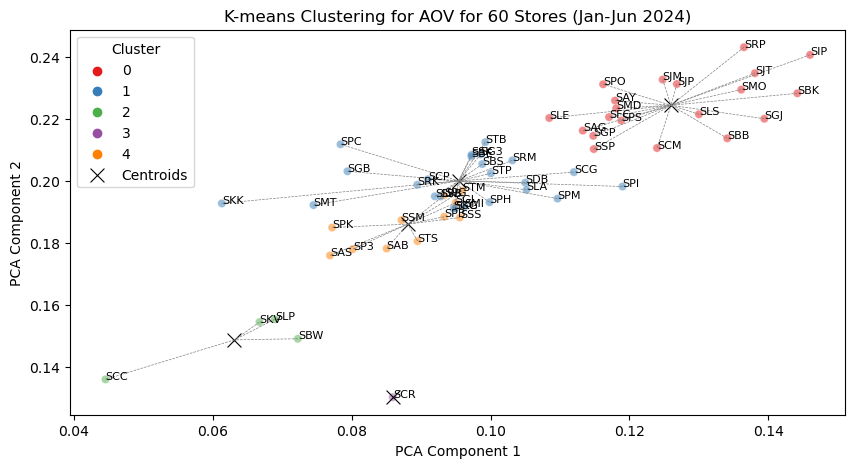

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

numerical_columns = df_normalized.select_dtypes(include=['float64']).columns


X = df_normalized[numerical_columns]
n_clusters = 5


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
centroids = kmeans.cluster_centers_

cluster_labels = kmeans.labels_

df_normalized['cluster'] = cluster_labels

def plot_clusters_with_centroids(X, cluster_labels, centroids, store_alias, title):
    # Plot clusters with centroids
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels, palette='Set1', legend='full', alpha=0.5)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

    # Connect data points to centroids with lines
    for i in range(len(X)):
        plt.plot([X[i, 0], centroids[cluster_labels[i], 0]], [X[i, 1], centroids[cluster_labels[i], 1]], color='gray', linestyle='--', linewidth=0.5)
        plt.text(X[i, 0], X[i, 1], store_alias[i], fontsize=8)  # Display store_alias for each data point

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Plot K-means clusters with centroids and lines
plot_clusters_with_centroids(X.values, cluster_labels, centroids, df_normalized.index, 'K-means Clustering for AOV for 60 Stores (Jan-Jun 2024)')


In [12]:
print(df_normalized)

aov_ad_range   a. <50k  b. >50k to 100k  c. >100k to 200k  d. >200k to 300k  \
store_alias                                                                   
SAB           0.085033         0.178113          0.299356          0.163126   
SAG           0.113297         0.216188          0.323671          0.145277   
SAS           0.076875         0.175877          0.302799          0.161478   
SAY           0.117939         0.225867          0.311353          0.146031   
SBB           0.134114         0.213707          0.315120          0.145881   
SBE           0.097246         0.207804          0.311668          0.154858   
SBK           0.144212         0.228233          0.304565          0.137726   
SBS           0.098817         0.205387          0.308980          0.159534   
SBW           0.072244         0.148980          0.260805          0.170368   
SCC           0.044535         0.135877          0.292532          0.179167   
SCG           0.112005         0.202773          0.3

In [13]:
print(X)

aov_ad_range   a. <50k  b. >50k to 100k  c. >100k to 200k  d. >200k to 300k  \
store_alias                                                                   
SAB           0.085033         0.178113          0.299356          0.163126   
SAG           0.113297         0.216188          0.323671          0.145277   
SAS           0.076875         0.175877          0.302799          0.161478   
SAY           0.117939         0.225867          0.311353          0.146031   
SBB           0.134114         0.213707          0.315120          0.145881   
SBE           0.097246         0.207804          0.311668          0.154858   
SBK           0.144212         0.228233          0.304565          0.137726   
SBS           0.098817         0.205387          0.308980          0.159534   
SBW           0.072244         0.148980          0.260805          0.170368   
SCC           0.044535         0.135877          0.292532          0.179167   
SCG           0.112005         0.202773          0.3

In [14]:
from sklearn.decomposition import PCA as pca

df_for_pca = df_normalized.drop(columns=['cluster'])

pca = pca(n_components=2)  # Number of components can be adjusted
pca.fit(df_for_pca)

def get_pca_component_scores(df_for_pca, pca):
    explained_variance_ratio = pca.explained_variance_ratio_

    abs_components = np.abs(pca.components_)


    component_scores = pd.DataFrame(abs_components.T, columns=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])
    component_scores['Attribute'] = df_for_pca.columns
    component_scores = component_scores.set_index('Attribute').apply(lambda x: x / x.sum(), axis=0)  # Normalize scores
    component_scores = component_scores.sort_values(by=['PC1', 'PC2'], ascending=False)  # Sort by influence on PC1 and PC2
    return component_scores

pca_component_scores = get_pca_component_scores(df_for_pca, pca)

print("PCA Component Scores:")
print(pca_component_scores)


PCA Component Scores:
                       PC1       PC2
Attribute                           
b. >50k to 100k   0.224450  0.096287
a. <50k           0.201476  0.155986
e. >300k to 500k  0.180169  0.021745
f. >500k to 1mio  0.168026  0.154699
d. >200k to 300k  0.088654  0.111050
c. >100k to 200k  0.074075  0.388950
g. >1mio to 3mio  0.060923  0.068219
h. >3mio to 5mio  0.001885  0.002590
i. >5mio          0.000343  0.000473


In [17]:
with pd.ExcelWriter('20240701 - ini kak Mandee minta utk stores 2023 below aja - yang raw datanya betul.xlsx') as writer:
    df_normalized.to_excel(writer, sheet_name='df_normalized', index=True)
    pca_component_scores.to_excel(writer, sheet_name='pca_component_scores')
    pivot_df.to_excel(writer, sheet_name='raw_data', index=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

centroids = kmeans.cluster_centers_

X = pivot_df
def plot_clusters_with_centroids(X, cluster_labels, centroids, store_alias, title):
    # Plot clusters with centroids
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels, palette='Set1', legend='full', alpha=0.5)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

# Connect data points to centroids with lines
    for i in range(len(X)):
        plt.plot([X[i, 0], centroids[cluster_labels[i], 0]], [X[i, 1], centroids[cluster_labels[i], 1]], color='gray', linestyle='--', linewidth=0.5)
        plt.text(X[i, 0], X[i, 1], store_alias[i], fontsize=8)  # Display store_alias for each data point

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Plot K-means clusters with centroids and lines
plot_clusters_with_centroids(X, cluster_labels, centroids, pivot_df.index, 'K-means Clustering with Centroids and Store Alias')





# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# centroids = kmeans.cluster_centers_



# def plot_clusters_with_centroids(X, cluster_labels, title):
#     # Fit KMeans to get cluster centroids
#     kmeans = KMeans(n_clusters=len(set(cluster_labels)), random_state=42)
#     kmeans.fit(X)
#     centroids = kmeans.cluster_centers_

#     # Plot clusters with centroids
#     plt.figure(figsize=(10, 5))
#     sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels, palette='Set1', legend='full', alpha=0.5)
#     sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
#     plt.title(title)
#     plt.xlabel('PCA Component 1')
#     plt.ylabel('PCA Component 2')
#     plt.legend(title='Cluster')

#     # Connect data points to centroids with lines
#     for i in range(len(X)):
#         plt.plot([X[i, 0], centroids[cluster_labels[i], 0]], [X[i, 1], centroids[cluster_labels[i], 1]], color='gray', linestyle='--', linewidth=0.5)
#     plt.show()
    
    


# # Plot K-means clusters with centroids and lines

# plot_clusters_with_centroids(X_pca, df['kmeans_cluster'], 'K-means Clustering (PCA Viz)')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# drop everything aside from id_order as key and category_default as attribute -- unsure about qty
df_cluster = df.drop(columns=["order_date", "platform_order", "store_alias", "store_name", "id_customer", "sku_ref", "product_name", "brand", "product_attribute", "before_discount", "after_discount","qty"])

one_hot_encoded = pd.get_dummies(df_cluster['category_default'], prefix='category')
df_cluster_encoded = pd.concat([df_cluster, one_hot_encoded], axis=1)
df_cluster_encoded.drop(columns=['category_default'], inplace=True)

df_cluster_encoded.head(20)

In [ ]:
X = df_cluster_encoded.drop(columns=['id_order'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


k = 5  # Number of neighbors
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)


clusters = kmeans.labels_
df_cluster_encoded['cluster'] = clusters

In [ ]:
# print(df_cluster_encoded[['id_order', 'cluster']].head(10))
print(df_cluster_encoded.head(30))

In [ ]:
#df_cluster_encoded.to_csv('cluster_encoded_full.csv', index=False)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality using PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

centroids = kmeans.cluster_centers_



# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)

# plt.figure(figsize=(10, 8))
# for i, centroid in enumerate(centroids):
#     cluster_points = X_pca[clusters == i]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=f'C{i}', alpha=0.5, label=f'Cluster {i}')    
#     plt.scatter(centroid[0], centroid[1], marker='X', s=200, color='red')
#     for point in cluster_points:
#         plt.plot([centroid[0], point[0]], [centroid[1], point[1]], c=f'C{i}', alpha=0.3)



plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SPK - K-Means Clustering (PCA)')
plt.colorbar(label='Cluster')
plt.show()

## Trying association rule mining algorithm: FP-Growth & Apriori

In [ ]:
df_for_arm = df.drop(columns=["order_date", "platform_order", "store_alias", "store_name", "id_customer", "sku_ref", "product_name", "brand", "product_attribute", "before_discount", "after_discount"])


df_for_arm.tail()

In [ ]:
def expand_rows(row):
    if row['qty'] > 1:
        return pd.DataFrame([row] * row['qty'], index=range(row['qty']))
    else:
        return pd.DataFrame([row])
    
expanded_df = pd.concat(df_for_arm.apply(expand_rows, axis=1).values)
expanded_df.reset_index(drop=True, inplace=True)
expanded_df.head(10)

In [ ]:
!pip install mlxtend

In [ ]:
#fpgrowth

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pandas as pd

fpgrowth_df = expanded_df.drop(columns=['qty'])
fpgrowth_df.dropna(inplace=True)


transaction_list = fpgrowth_df.groupby('id_order')['category_default'].apply(list).values.tolist()
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
df_binary = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df_binary, min_support=0.01, use_colnames=True)
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# print(frequent_itemsets)

print(frequent_itemsets_sorted)


In [ ]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets_apriori = apriori(df_binary, min_support=0.01, use_colnames=True)
print(frequent_itemsets_apriori)


In [ ]:
frequent_itemsets_apriori_sorted = frequent_itemsets_apriori.sort_values(by='support', ascending=False)
print(frequent_itemsets_apriori_sorted)

In [ ]:
#download results to csv
#please change the name according to store

file_path = 'spk_association_results.xlsx'

with pd.ExcelWriter(file_path) as writer:
    frequent_itemsets.to_excel(writer, sheet_name='fpgrowth', index=False)
    frequent_itemsets_apriori.to_excel(writer, sheet_name='apriori', index=False)

###Visualization

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx

G = nx.Graph()

for idx, row in frequent_itemsets.iterrows():
    for item in row['itemsets']:
        G.add_node(item)


for idx, row in frequent_itemsets.iterrows():
    items = list(row['itemsets'])  # Convert frozenset to list
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                G.add_edge(items[i], items[j], weight=row['support'])



pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)


edge_labels = {(u, v): round(d['weight'], 4) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


plt.title('SPK - Association Network Graph')
plt.show()

In [ ]:
#apriori
import networkx as nx

G = nx.Graph()

for idx, row in frequent_itemsets_apriori.iterrows():
    for item in row['itemsets']:
        G.add_node(item)


for idx, row in frequent_itemsets_apriori.iterrows():
    items = list(row['itemsets'])  # Convert frozenset to list
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                G.add_edge(items[i], items[j], weight=row['support'])



pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)


edge_labels = {(u, v): round(d['weight'], 4) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


plt.title('SPK - Association Network Graph')
plt.show()

In [ ]:
## stop here

In [ ]:
import seaborn as sns

itemsets_matrix = pd.DataFrame(index=te.columns_, columns=te.columns_)
itemsets_matrix.fillna(0, inplace=True)


for idx, row in frequent_itemsets_apriori.iterrows():
    items = list(row['itemsets'])
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                itemsets_matrix.loc[items[i], items[j]] = row['support']
                itemsets_matrix.loc[items[j], items[i]] = row['support']


plt.figure(figsize=(10, 8))
sns.heatmap(itemsets_matrix, cmap="YlGnBu", annot=True, fmt=".3f")
plt.title('Association Heatmap')
plt.xlabel('Itemset')
plt.ylabel('Itemset')
plt.show()

In [ ]:
# T-distributed Stochastic Neighbor Embedding (t-SNE)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality using t-SNE to 2 components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-Means Clustering (t-SNE)')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score

2. Initial Clustering on Variable Categories

Drop the store_name column to extract only the features in the dataset.

In [ ]:
df_group1_features = df_group1.drop(columns=['store_name'])
df_group2_features = df_group2.drop(columns=['store_name'])
df_group3_features = df_group3.drop(columns=['store_name'])
df_group4_features = df_group4.drop(columns=['store_name'])
df_group5_features = df_group5.drop(columns=['store_name'])


In [ ]:
#test content
df_group4_features.head()

Categorical columns only exist in group 4 (area_category, city_type). Hence, we do encoding to scale those values to 0 - 1. For the rest of the numeric columns, we use a scaler function to normalize the values.

3. Standardization/Normalization Data Pre-Processing - because K-means is VERY sensitive to the scale of features

In [ ]:
# scaling for all groups with numerical features only
scaler = StandardScaler()
df_group1_features_scaled = scaler.fit_transform(df_group1_features)
df_group2_features_scaled = scaler.fit_transform(df_group2_features) # not sure if aov needs scaling but let's try both
df_group3_features_scaled = scaler.fit_transform(df_group3_features)
df_group5_features_scaled = scaler.fit_transform(df_group5_features)


In [ ]:
# change this part to test
original_dataset = df_group3_features
check_dataset = df_group3_features_scaled

check_dataset = pd.DataFrame(check_dataset, columns=original_dataset.columns)
check_dataset.head()

In [ ]:
# scaling and encoding for df_group4_features which has both numerical and categorical columns

# Define the column names
categorical_columns = ['area_category', 'city_type']
numerical_columns = ['store_size', 'sales_per_sqm', 'store_life']

# Create transformers for numerical and categorical columns
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform the data
df_group4_features_scaled = preprocessor.fit_transform(df_group4_features)

# Get the column names after transformation
numerical_columns_list = numerical_columns
categorical_columns_list = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Combine numerical and categorical column names
columns = numerical_columns_list + list(categorical_columns_list)

# Create a DataFrame with the scaled features
df_group4_features_scaled = pd.DataFrame(df_group4_features_scaled, columns=columns)

# Print the first few rows of the transformed 
print(df_group4_features_scaled.head())

In [ ]:
# convert result back to dataframe to test

columns = list(numerical_columns) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns))
# columns = list(numerical_columns) + list(categorical_columns)
df_group4_features_scaled_check = pd.DataFrame(df_group4_features_scaled, columns=columns)
print(df_group4_features_scaled_check.head())

In [ ]:
# Print the number of columns and rows
num_rows, num_columns = df_group4_features_scaled_check.shape
print(f"Number of columns: {num_columns}")
print(f"Number of rows: {num_rows}")

# Print the DataFrame to check the first few rows
print(df_group4_features_scaled_check.head())

columns_list = df_group4_features_scaled_check.columns.tolist()
print("Column names:")
print(columns_list)


4. Running k-means algorithm with k=5 or k=6 on each of the mini clusters using loop function

In [ ]:
num_clusters = 5 # or 6

#-----------
# GROUP 1
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group1_features_scaled, pd.DataFrame):
    df_group1_features_scaled = pd.DataFrame(df_group1_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group1_features_scaled)

df_group1_clustered = df_group1_features_scaled.copy()
df_group1_clustered['Cluster'] = clusters


#-----------
# GROUP 2
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group2_features_scaled, pd.DataFrame):
    df_group2_features_scaled = pd.DataFrame(df_group2_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group2_features_scaled)

df_group2_clustered = df_group2_features_scaled.copy()
df_group2_clustered['Cluster'] = clusters

#-----------
# GROUP 3
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group3_features_scaled, pd.DataFrame):
    df_group3_features_scaled = pd.DataFrame(df_group3_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group3_features_scaled)

df_group3_clustered = df_group3_features_scaled.copy()
df_group3_clustered['Cluster'] = clusters


#-----------
# GROUP 4
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group4_features_scaled, pd.DataFrame):
    df_group4_features_scaled = pd.DataFrame(df_group4_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group4_features_scaled)

df_group4_clustered = df_group4_features_scaled.copy()
df_group4_clustered['Cluster'] = clusters

#-----------
# GROUP 5
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group5_features_scaled, pd.DataFrame):
    df_group5_features_scaled = pd.DataFrame(df_group5_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group5_features_scaled)

df_group5_clustered = df_group5_features_scaled.copy()
df_group5_clustered['Cluster'] = clusters


5. PCA centroid plotting to show the distribution of the datapoints for each mini-cluster 

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# List of mini-cluster dataframes
mini_clusters = [df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered]

# Define a custom color palette for clusters
custom_palette = sns.color_palette("Set1", n_colors=len(mini_clusters))

# Apply PCA and plot for each mini-cluster
for i, mini_cluster in enumerate(mini_clusters, 1):
    # Extract the feature columns (excluding 'Cluster' column)
    feature_columns = mini_cluster.columns.difference(['Cluster'])

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(mini_cluster[feature_columns])

    # Create a new dataframe with PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = mini_cluster['Cluster']

    # Plot the PCA results for each mini-cluster with custom size and color palette
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30)
    plt.title(f'PCA Plot of Mini-Cluster {i}')
    plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
# import seaborn as sns
# import matplotlib.pyplot as plt

# # List of mini-cluster dataframes
# mini_clusters = [df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered]
# # Define a custom color palette for clusters using 'Set1'
# custom_palette = sns.color_palette("Set1", n_colors=len(mini_clusters))

# # Apply DBSCAN and plot for each mini-cluster
# for i, mini_cluster in enumerate(mini_clusters, 1):
#     # Extract the feature columns (excluding 'Cluster' column)
#     feature_columns = mini_cluster.columns.difference(['Cluster'])

#     # Apply PCA
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(mini_cluster[feature_columns])

#     # Apply DBSCAN
#     dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples
#     labels = dbscan.fit_predict(pca_result)

#     # Create a new dataframe with PCA results and cluster labels
#     df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     df_pca['Cluster'] = labels

#     # Calculate centroids
#     centroids = df_pca.groupby('Cluster').mean()

#     # Plot the DBSCAN clustering results for each mini-cluster with custom size and color palette
#     plt.figure(figsize=(8, 6))
#     for cluster, centroid in centroids.iterrows():
#         points_in_cluster = df_pca[df_pca['Cluster'] == cluster][['PC1', 'PC2']].values
#         for point in points_in_cluster:
#             plt.plot([point[0], centroid['PC1']], [point[1], centroid['PC2']], 'k-', alpha=0.3)  # Lines from points to centroid
#         plt.plot(centroid['PC1'], centroid['PC2'], 'o', color=custom_palette[cluster], markersize=10)  # Plot centroid
#     sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points
#     plt.title(f'DBSCAN Clustering Plot with Point-Centroid Connections for Mini-Cluster {i}')
#     plt.legend()
#     plt.show()

    

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# List of mini-cluster dataframes
mini_clusters = [df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered]
# Create a list to store PCA models for each mini-cluster
MiniCluster_PCAs = []
# Define a custom color palette for clusters using 'Set1'
custom_palette = sns.color_palette("Set1", n_colors=len(mini_clusters))

# Apply PCA and plot for each mini-cluster
for i, mini_cluster in enumerate(mini_clusters, 1):
    # Extract the feature columns (excluding 'Cluster' column)
    feature_columns = mini_cluster.columns.difference(['Cluster'])

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(mini_cluster[feature_columns])
    # Store PCA model in the list
    MiniCluster_PCAs.append(pca)

    # Create a new dataframe with PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = mini_cluster['Cluster']

    # Calculate centroids
    centroids = df_pca.groupby('Cluster').mean()

    # Plot the PCA results for each mini-cluster with custom size and color palette
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30)

    # Draw lines from each point to its cluster centroid
    for cluster, centroid in centroids.iterrows():
        points_in_cluster = df_pca[df_pca['Cluster'] == cluster][['PC1', 'PC2']].values
        for point in points_in_cluster:
            plt.plot([point[0], centroid['PC1']], [point[1], centroid['PC2']], 'k-', alpha=0.3)  # Lines from points to centroid
        plt.plot(centroid['PC1'], centroid['PC2'], 'o', color=custom_palette[cluster], markersize=10)

    plt.title(f'PCA Plot with Point-Centroid Connections for Mini-Cluster {i}')
    plt.legend()
    plt.show()


In [ ]:
df_group1_result = df_group1.copy()
df_group1_result['Cluster'] = df_group1_clustered['Cluster']

df_group2_result = df_group2.copy()
df_group2_result['Cluster'] = df_group2_clustered['Cluster']

df_group3_result = df_group3.copy()
df_group3_result['Cluster'] = df_group3_clustered['Cluster']

df_group4_result = df_group4.copy()
df_group4_result['Cluster'] = df_group4_clustered['Cluster']

df_group5_result = df_group5.copy()
df_group5_result['Cluster'] = df_group5_clustered['Cluster']

#to test
print("Combined Dataframe:")
print(df_group1_result.head())

In [ ]:
!pip install openpyxl
# Display the clustered results for each group
output_file = 'clustered_results_20240229.xlsx'

# Create an Excel writer
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write each dataframe to a separate sheet
    df_group1_result.to_excel(writer, sheet_name='df_group1_result', index=False)
    df_group2_result.to_excel(writer, sheet_name='df_group2_result', index=False)
    df_group3_result.to_excel(writer, sheet_name='df_group3_result', index=False)
    df_group4_result.to_excel(writer, sheet_name='df_group4_result', index=False)
    df_group5_result.to_excel(writer, sheet_name='df_group5_result', index=False)

-----Notes on Interpreting the Mini-Clusters-----

Interpreting PCA plots involves understanding the principal components (PC1 and PC2) and their relationship with the original features in your dataset. Here are some general guidelines for interpreting PCA plots:

1. Principal Components (PC1 and PC2):

PC1: This is the first principal component, and it represents the direction in the data with the maximum variance. It captures the most significant patterns in the data.
PC2: This is the second principal component, orthogonal (uncorrelated) to PC1, and it represents the second largest source of variance.

2. Variance Explained:

Look at the explained variance ratio for each principal component. This indicates the proportion of total variance in the data that is captured by each component. You can access this information using pca.explained_variance_ratio_.

3. Interpreting Loadings:

Loadings represent the contribution of each original feature to the principal components. Positive and negative loadings indicate the direction of the feature's influence on the component.
The larger the absolute value of the loading, the more the feature contributes to that principal component.

4.Cluster Separation:

Observe how well-separated the clusters are in the PCA plot. If clusters are distinct, it indicates that the original features contribute to a meaningful separation.
If clusters overlap or are close, it might suggest that the features do not provide clear separation along these principal components.

5.Point-Centroid Connections:

The lines connecting each point to its cluster centroid in your plot show the direction and magnitude of the relationship between the point and the centroid.
If a point is close to the centroid, it suggests that the features of that point are well-represented by the principal components.

6.Correlation with Original Features:

If you have access to the loadings of each principal component, you can check which original features contribute most to the direction of each principal component. Positive and negative loadings indicate the direction of influence.


Here's a general interpretation:

Points that are close together on the plot share similar patterns of variation based on the original features.
Distances between points and centroids reflect how well a point is represented by its cluster's centroid in the reduced-dimensional space.

In [ ]:
! pip install xlsxwriter
with pd.ExcelWriter('pca_results_20240929.xlsx', engine='xlsxwriter') as writer:
    # Iterate through mini-clusters
    for i, mini_cluster in enumerate(mini_clusters, 1):
        # Access the previously fitted PCA model
        pca_model = MiniCluster_PCAs[i-1]  # Assuming you stored your PCA models in MiniCluster_PCAs list during the initial clustering

        # Extract the feature columns (excluding 'Cluster' column)
        feature_columns = mini_cluster.columns.difference(['Cluster'])

        # Store loadings in a DataFrame with original column names
        loadings_df = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, pca_model.n_components_ + 1)], index=feature_columns)

        # Print or store loadings for each mini-cluster
        print(f"Loadings for Mini-Cluster {i}:")
        print(loadings_df)

        # Add loadings DataFrame to the dictionary
        loadings_dict[f'MiniCluster_{i}'] = loadings_df

        # Save loadings to Excel file
        loadings_df.to_excel(writer, sheet_name=f'MiniCluster_{i}')

# Access loadings for a specific mini-cluster (e.g., MiniCluster_1)
# print("Loadings for Mini-Cluster 1:")
# print(loadings_dict['MiniCluster_4'])

In [ ]:

loadings_dict = {}

# Iterate through mini-clusters
for i, mini_cluster in enumerate(mini_clusters, 1):
    # Access the previously fitted PCA model
    pca_model = MiniCluster_PCAs[i-1]  # Assuming you stored your PCA models in MiniCluster_PCAs list during the initial clustering

    # Extract the feature columns (excluding 'Cluster' column)
    feature_columns = mini_cluster.columns.difference(['Cluster'])

    # Store loadings in a DataFrame with original column names
    loadings_df = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, pca_model.n_components_ + 1)], index=feature_columns)

    # Print or store loadings for each mini-cluster
    print(f"Loadings for Mini-Cluster {i}:")
    print(loadings_df)

    # Add loadings DataFrame to the dictionary
    loadings_dict[f'MiniCluster_{i}'] = loadings_df


# Access loadings for a specific mini-cluster (e.g., MiniCluster_1)
# print("Loadings for Mini-Cluster 1:")
# print(loadings_dict['MiniCluster_1'])


In [ ]:
output_file = 'pca_result_20240229.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in loadings_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)


7. Final clustering using attributes of membership values in 5 mini-clusters for each data point

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Combine the clustered mini-groups
df_combined = pd.concat([df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered])

# Extract the membership values for each mini-group
membership_columns = ['Cluster']

# Extract the features for the final k-means clustering
final_features = df_combined[membership_columns]

# Run the final k-means clustering
final_num_clusters = 5  # or 6
final_kmeans = KMeans(n_clusters=final_num_clusters, random_state=42)
final_clusters = final_kmeans.fit_predict(final_features)

# Add the final cluster column to the combined dataframe
df_combined['FinalCluster'] = final_clusters

# Display the combined dataframe with final cluster assignments
print("Combined Dataframe with Final Cluster Assignments:")
print(df_combined.head())

# Optionally, you can save the combined dataframe with final cluster assignments to an Excel file
df_combined.to_excel('final_cluster_results.xlsx', index=False)


In [ ]:
# Assuming 'transformed_features' is defined somewhere in your code
# Make sure 'transformed_features' has the same number of columns as your original dataset

# Check the number of columns in df and transformed_features
print("Number of columns in df_features:", df_features.shape[1])
print("Number of columns in transformed_features:", transformed_features.shape[1])

# Check if the number of columns matches
if df_features.shape[1] != transformed_features.shape[1]:
    print("Number of columns in df_features and transformed_features do not match. Adjust the datasets.")

else:
    # Visualize the clusters using PCA for dimensionality reduction
    pca = PCA(n_components=5)
    df_pca = pd.DataFrame(pca.fit_transform(transformed_features_check), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

    # Get the loadings of the original variables on each principal component
    loadings = pca.components_

    # Create a DataFrame to display the loadings
    loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_features.columns[:-1])

    # Display the loadings
    print("Loadings of Original Variables on Each Principal Component:")
    print(loadings_df)


In [ ]:
## Assuming 'transformed_features' is defined somewhere in your code
# Make sure 'transformed_features' has the same number of columns as your original dataset

# Check the number of columns in df and transformed_features
print("Number of columns in df_features:", df_features.shape[1])
print("Number of columns in transformed_features:", transformed_features.shape[1])

# Drop the extra column in transformed_features
transformed_features = transformed_features[:, :df_features.shape[1]]

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=5)
df_pca = pd.DataFrame(pca.fit_transform(transformed_features), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Get the loadings of the original variables on each principal component
loadings = pca.components_

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_features.columns)

# Display the loadings
print("Loadings of Original Variables on Each Principal Component:")
print(loadings_df[['PC1', 'PC2']])

# Display the variables ranked by their influence on the first principal component
print("\nVariables ranked by influence on PC1:")
print(loadings_df['PC1'].abs().sort_values(ascending=False))

# Display the variables ranked by their influence on PC2
print("\nVariables ranked by influence on PC2:")
print(loadings_df['PC2'].abs().sort_values(ascending=False))


In [ ]:
# Save the loadings for PC1 and PC2 to a CSV file
loadings_df[['PC1', 'PC2']].to_csv('loadings_pc1_pc2.csv')

In [ ]:
for cluster_num, group in df.groupby('cluster'):
    print(f"Cluster {cluster_num}:\n")
    print(group)
    print("\n" + "="*50 + "\n")


In [ ]:
# this code downloads the results to check the clustering validity
import os
df['cluster'] = kmeans.fit_predict(transformed_features)
unique_clusters = df['cluster'].unique()

# Group by 'cluster' and store each cluster as a separate DataFrame
cluster_results = {cluster_num: group for cluster_num, group in df.groupby('cluster')}
save_directory = 'C:/Users/tiara.santoso/Downloads/Data Exports'

# Save each cluster as a separate CSV file
# for cluster_num in unique_clusters:
#     cluster_df = cluster_results[cluster_num]
#     file_path = os.path.join(save_directory, f'cluster_{cluster_num}_results.csv')
#     cluster_df.to_csv(file_path, index=False)

# Alternatively, concatenate all clusters into a single DataFrame and save as one CSV file
all_cluster_df = pd.concat(list(cluster_results.values()), ignore_index=True)
all_file_path = os.path.join(save_directory, '20240117-all_clusters_results_1.1_without_outliers_clusters2.csv')
all_cluster_df.to_csv(all_file_path, index=False)


In [ ]:
features = ['net_rev_monthly','after_discount','percentage_disc_to_nmv','aov_amount','order_count','quantity_count','unique_shoppers',
            'guest_order','store_size','sales_per_sqm','store_life','cat_skincare','cat_makeup','cat_bath_and_body','cat_haircare','cat_accessories',
            'cat_fragrance','cat_supplement','cat_shaving_grooming','cat_nailcare','cat_sanitary','cat_oralcare','cat_homecare','cat_nursing_feeding','cat_fashion',
            'cat_bedding_bathroom','cat_miscellaneous','area_category','city_type','aovdis<=50k','aovdis50-100k','aovdis100-200k','aovdis200-300k','aovdis>300k',
            'omni_shopper','offline_only','online_order','offline_order','pickup_shopper','pickup_order']

cluster_stats = df.groupby('cluster')[features].describe()
print(cluster_stats)

In [ ]:

cluster_stats = df.groupby('cluster')[features].describe()

save_directory = r'C:\Users\tiara.santoso\Downloads\Data Exports'
cluster_stats.to_csv(os.path.join(save_directory, '20240117-cluster_stats_outliers2.csv'))

In [ ]:
import seaborn as sns

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'Distribution of {feature} within Clusters')
    plt.show()

In [ ]:
import seaborn as sns


In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(df['aov_amount'], df['unique_shoppers'], df['store_size'], c=df['cluster'], cmap='viridis', alpha=0.7)

ax.set_xlabel('AOV Amount')
ax.set_ylabel('Unique Shoppers')
ax.set_zlabel('Store Size')
ax.set_title('K-Means Clustering (5 Clusters) - 3D Visualization')

# Add a legend
legend_labels = np.unique(df['cluster'])
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

plt.show()